In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import r2_score, mean_squared_error

In [220]:
!pip install -U statsmodels

In [221]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

File ‘perrin-freres-monthly-champagne.csv’ already there; not retrieving.



In [222]:
!head perrin-freres-monthly-champagne.csv

Month,Perrin Freres monthly champagne sales millions ?64-?72
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946
1964-06,3036
1964-07,2282
1964-08,2212
1964-09,2922


In [223]:
df = pd.read_csv(
    'perrin-freres-monthly-champagne.csv',
    index_col='Month',
    skipfooter=2,
    parse_dates=True)

/tmp/ipython-input-1153254689.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(


In [224]:
df.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [225]:
df.columns = ['Sales']

<Axes: xlabel='Month'>

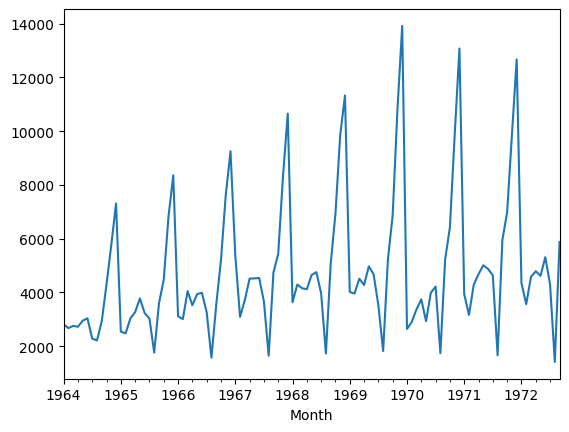

In [226]:
df['Sales'].plot()

In [227]:
df.index.freq = 'MS'

In [228]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [229]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [230]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [231]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul']
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
use_boxcox_list = [True, False, 0]

In [232]:
def runModels(trend_type,seasonal_type,init_method,use_boxcox,debug=False):
  hw = ExponentialSmoothing(
        train['Sales'],
        initialization_method=init_method,
        trend=trend_type,
        seasonal=seasonal_type,
        seasonal_periods=12,
        use_boxcox=use_boxcox)
  res_hw = hw.fit()
  rscore = r2_score(test['Sales'], res_hw.forecast(Ntest))
  if debug:
    print("R2_score is: ", rscore," for parameters ",trend_type," ",seasonal_type," ",init_method," ",use_boxcox," ",debug)
  return rscore

In [233]:
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    init_method_list,
    use_boxcox_list,
)
best_rscore = float('-inf')
best_options = None
# running model on all possible combinations of HYPER-PARAMETERS
for x in itertools.product(*tuple_of_option_lists):
  rscore = runModels(*x)

  if rscore > best_rscore:
    print("Best r2_score so far:", rscore)
    best_rscore = rscore
    best_options = x

Best r2_score so far: 0.9871548049126242


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [234]:
print("best r2_score: ", best_rscore)

best_trend_type, best_seasonal_type, best_init_method, best_use_boxcox = best_options
print("trend_type", best_trend_type)
print("seasonal_type", best_seasonal_type)
print("init_method", best_init_method)
print("use_boxcox", best_use_boxcox)

best r2_score:  0.9871548049126242
trend_type add
seasonal_type add
init_method estimated
use_boxcox True


In [235]:
hw = ExponentialSmoothing(
    train['Sales'],
    initialization_method=best_init_method,
    trend=best_trend_type,
    seasonal=best_seasonal_type,
    seasonal_periods=12,
    use_boxcox=best_use_boxcox)
res_hw = hw.fit()

In [236]:
df.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues

In [237]:
df.loc[test_idx, 'HoltWintersTest'] = res_hw.forecast(Ntest)

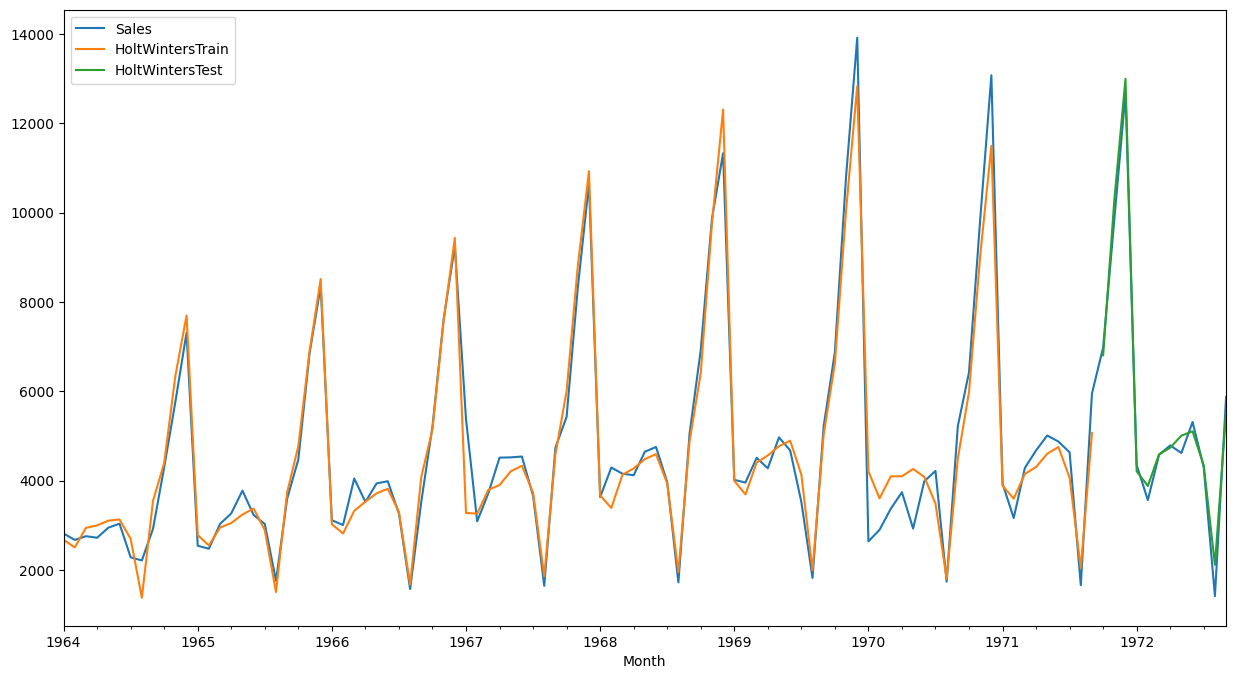

In [238]:
df[['Sales', 'HoltWintersTrain', 'HoltWintersTest']].plot(figsize=(15, 8));

In [239]:
r2_score(train['Sales'], res_hw.fittedvalues)

0.9550493990822672

In [240]:
r2_score(test['Sales'], res_hw.forecast(Ntest))

0.9871548049126242